## LASSO and Random Forest fits

for polynomial basis

$B_x, B_y, B^2, B_x B_y, B^2 B_x, B^2 B_y$

# Load/import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
#from sklearn.metrics import mean_squared_error,mean_absolute_error

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from preprocess import *

## Download data for Rm = $1.5 \times 10^4$

In [ ]:
!wget -O mfields_R15e3.npz https://sid.erda.dk/public/archives/0cf0c2b6d34e20da8971304b06d8f913/pencil/alpha2/shock_k10_R15000_256_xyaver_alpha_eta/mfields.npz

## Pre-process

Time averaged data stored in a pandas dataframe

In [3]:
df15 = gen_df_tave(fname='mfields_R15e3.npz',t1=1500,t2=-1,verbose=0)
#df05 = gen_df_tave(fname=pth + 'mfields_R5e2.npz',t1=4000,t2=5000,verbose=0)

In [4]:
df15.head()

,Bx,By,Jx,Jy,Ex,Ey
0,0.700520,0.705890,-0.602242,-0.644567,0.000467,0.000502
1,0.684174,0.720619,-0.598669,-0.688552,0.000453,0.000515
2,0.666762,0.735254,-0.594767,-0.729381,0.000439,0.000527
3,0.648423,0.749906,-0.600635,-0.764473,0.000425,0.000538
4,0.629228,0.764784,-0.610741,-0.799537,0.000411,0.000551


### Generate polynomial basis

In [17]:
df15_poly = gen_df_poly(df15)
df15_ss, scl = scale_df(df15_poly)
df15_ss.head()

Feature names: ['Bx', 'By', 'Bx By', 'Ex', 'Ey', 'B^2', 'B^2 Bx', 'B^2 By']
Feature array shape: (256, 8)


,Ex,Ey,B^2,B^2 Bx,B^2 By,Bx,By,Bx By
0,0.941561,1.064997,0.419213,1.021195,1.003289,0.996046,1.018508,1.445872
1,0.914499,1.092287,0.370750,0.995885,1.022960,0.972804,1.039760,1.441586
2,0.886233,1.118527,0.304606,0.968535,1.041787,0.948046,1.060878,1.433406
3,0.858595,1.143628,0.234177,0.939827,1.060384,0.921970,1.082018,1.421723
4,0.830579,1.169738,0.174791,0.910358,1.079619,0.894679,1.103484,1.406963


# Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression
from preprocess import train_test_seq

lr = LinearRegression(fit_intercept=False)

fld  = ['Ex']
flds = ['Ex','Ey']
tst_sz = 0.2

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_seq(df15_ss.drop(flds,axis=1),df15_ss[fld],test_size=tst_sz)
lr.fit(X_train_lr,y_train_lr)
y_pred_lr = lr.predict(X_test_lr)
lr.coef_

Test size: 0.2


array([[-0.03765302, -1.72005983, -0.25122688,  2.70080227,  0.23687589,
         0.01737001]])

In [11]:
# Find out how the coefficients are ordered
df15_ss.drop(flds,axis=1).columns

Index(['B^2', 'B^2 Bx', 'B^2 By', 'Bx', 'By', 'Bx By'], dtype='object')

# Lasso

In [12]:
from lasso_fits import *

## Polynomial basis

Test size: 0.2
Test,train shapes: (52, 6) (204, 6)
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.2s finished
/home/fnauman/anaconda3/envs/plotly/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023950232811909722, tolerance: 0.01638960849288989
  positive)


Means of CV folds: [-0.25634852 -0.66159821 -0.72946833 -0.79179278 -0.89966289]
STDs of CV folds : [0.16002384 0.60651159 0.63689181 0.46256559 0.29573615]
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.022597      0.018956         0.001044        0.000150   
1       0.003197      0.000085         0.001063        0.000019   
2       0.002876      0.000292         0.000979        0.000070   
3       0.002092      0.000030         0.000979        0.000023   
4       0.002072      0.000021         0.000921        0.000025   

  param_lasso__alpha                   params  split0_test_score  \
0              0.001  {'lasso__alpha': 0.001}          -0.416372   
1               0.01   {'lasso__alpha': 0.01}          -1.268110   
2                0.1    {'lasso__alpha': 0.1}          -1.366360   
3                0.5    {'lasso__alpha': 0.5}          -1.254358   
4                  1    {'lasso__alpha': 1.0}          -1.195399   

   split1_test_score  mean_test

/home/fnauman/anaconda3/envs/plotly/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023950232811909722, tolerance: 0.01638960849288989
  positive)


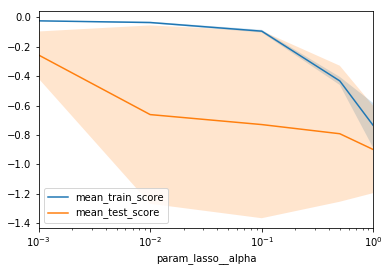

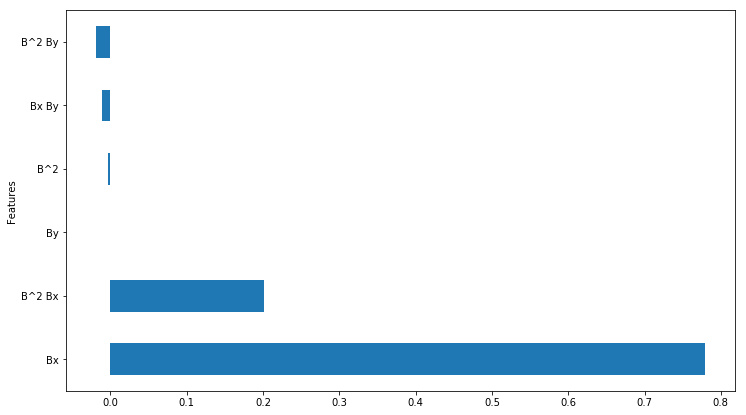

In [13]:
y_train,y_pred,y_test = lasso_gridcv(df15_ss)

# Random forests

In [14]:
from rf_fits import *

## Polynomial basis

Test size: 0.2
Test,train shapes: (52, 6) (204, 6)
Fitting 2 folds for each of 108 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:    1.6s finished


Means of CV folds: [-0.60503767 -0.55430146 -0.51295055 -0.47670458 -0.60503767 -0.55430146
 -0.51295055 -0.47670458 -0.60503767 -0.55430146 -0.51295055 -0.47670458
 -0.8100654  -0.7787325  -0.79260837 -0.63599411 -0.8100654  -0.78010976
 -0.79359844 -0.63683346 -0.8100654  -0.7834072  -0.79667333 -0.63906597
 -0.60503767 -0.55430146 -0.51295055 -0.47670458 -0.60503767 -0.55430146
 -0.51295055 -0.47670458 -0.60503767 -0.55430146 -0.51295055 -0.47670458
 -0.52963479 -0.47900649 -0.41923    -0.37879163 -0.4092854  -0.41516275
 -0.39126886 -0.36941743 -0.53644277 -0.48191415 -0.42774743 -0.39797061
 -0.54662896 -0.58039696 -0.62865211 -0.55589805 -0.55175669 -0.58863083
 -0.64097492 -0.56090157 -0.64965823 -0.65206733 -0.69771532 -0.61413344
 -0.52963479 -0.47900649 -0.41923    -0.37879163 -0.4092854  -0.41516275
 -0.39126886 -0.36941743 -0.53644277 -0.48191415 -0.42774743 -0.39797061
 -0.35088052 -0.34622565 -0.3598842  -0.34501613 -0.37768149 -0.38122616
 -0.36163671 -0.34059363 -0.5492

<Figure size 432x288 with 0 Axes>

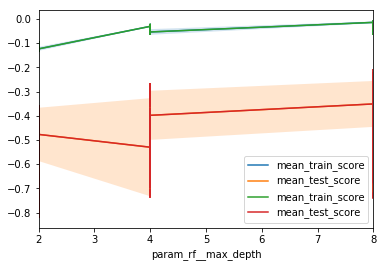

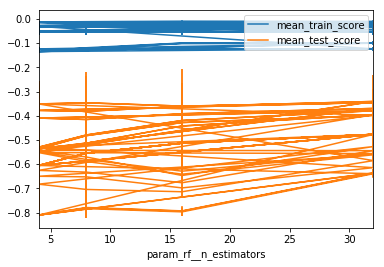

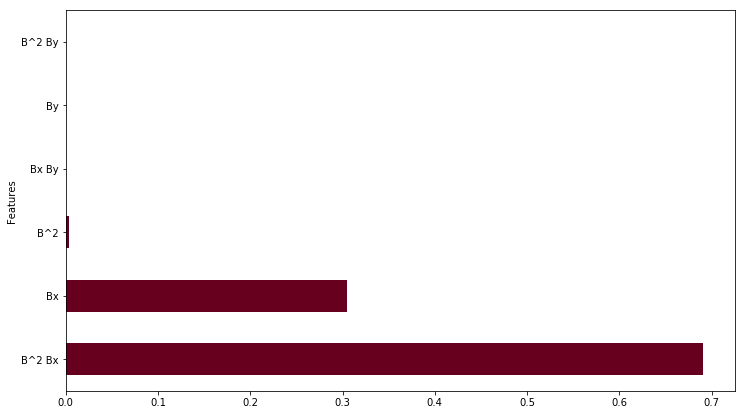

In [15]:
y_trainrf,y_predrf,y_testrf = rf_gridcv(df15_ss)#, fi_plts=True)

## Comparison: RF vs LASSO

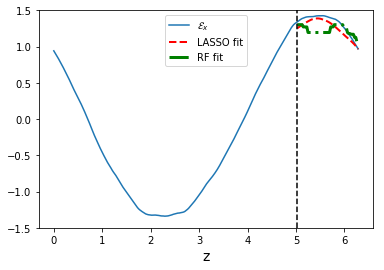

In [16]:
z_ax = np.linspace(0,2*np.pi,256)

fig,ax=plt.subplots()
        
fld_label = r"$\mathcal{E}_x$" #if fld=='Ex' else r"$\mathcal{E}_y$"
        
ax.plot(np.linspace(0,2*np.pi,256),df15_ss['Ex'],label=fld_label)
ax.plot(z_ax[y_train.shape[0]:],y_pred,'r--',lw=2,label="LASSO fit")
ax.plot(z_ax[y_train.shape[0]:],y_predrf,'g-.',lw=3,label="RF fit")

plt.axvline(x=0.8*z_ax[-1], color='k', linestyle='--')

ax.set_ylim([-1.5,1.5])
    
ax.legend()
ax.set_xlabel('z',fontsize=14)
    
fig.savefig('df15_SPACE_comparison_poly.pdf',bbox_inches='tight')